In [9]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
import glob
import json
import scipy.signal as sig
import scipy.interpolate as intp
from scipy.ndimage import gaussian_filter

Load in all the data - the file names are included in the json file organized by event (there are 4 of them).

In [3]:
# Read in data, from both Livingston and Haverford, need to specify which event (4 of them)

data_directory = 'LOSC_Event_tutorial/'

with open(data_directory+'BBH_events_v3.json') as file:
    json_dat = json.load(file)

list_events = list(json_dat.keys())
print('Different event names: ', list_events)

Different event names:  ['GW150914', 'LVT151012', 'GW151226', 'GW170104']


In [4]:
# functions from simple_read_ligo.py

def read_template(filename,):
    dataFile=h5py.File(filename,'r')
    template=dataFile['template']
    th=template[0]
    tl=template[1]
    return th,tl
def read_file(filename):
    dataFile=h5py.File(filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]

    meta=dataFile['meta']
    #gpsStart=meta['GPSstart'].value
    gpsStart=meta['GPSstart'][()]
    #print meta.keys()
    #utc=meta['UTCstart'].value
    utc=meta['UTCstart'][()]
    #duration=meta['Duration'].value
    duration=meta['Duration'][()]
    #strain=dataFile['strain']['Strain'].value
    strain=dataFile['strain']['Strain'][()]
    dt=(1.0*duration)/len(strain)

    dataFile.close()
    return strain,dt,utc

In [5]:
# Read in all data, make separate lists for H1,L1 data and templates (templates same for each event)
N_events = len(list_events)
H1_data = [] # data for Hanford events (strain,dt,utc)
L1_data = [] # data for Livingston events
H_templates = [] # templates for Hanford for each event
L_templates = [] # templates for Livingston for each event

for i in range(N_events):
    event_name = str(list_events[i])
    H1_fname = json_dat[event_name]['fn_H1']
    L1_fname = json_dat[event_name]['fn_L1']
    fn_temp = json_dat[event_name]['fn_template']
    H1_data.append(read_file(data_directory+H1_fname))
    L1_data.append(read_file(data_directory+L1_fname))
    H_temp, L_temp = read_template(data_directory+fn_temp)
    H_templates.append(H_temp), L_templates.append(L_temp);
    
file.close() # close json object

In [6]:
H1_dt = [H1_data[i][1] for i in range(N_events)] # get dt for each detector
L1_dt = [L1_data[i][1] for i in range(N_events)]

We can plot the data for each event along with the corresponding template.

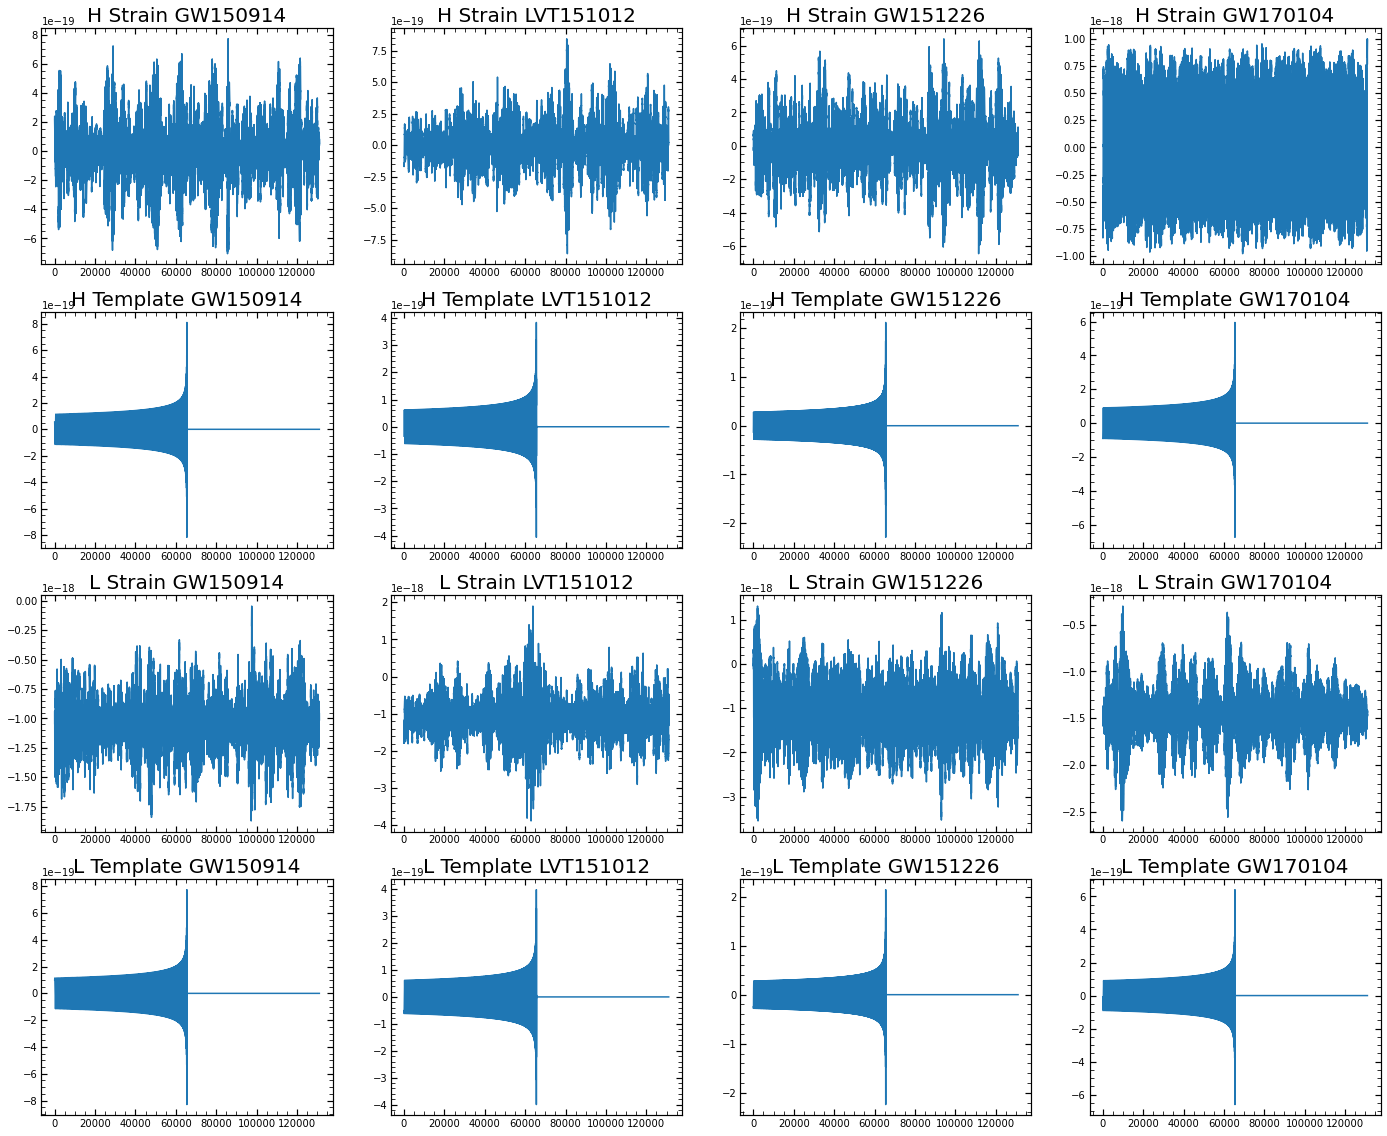

In [7]:
nrows, ncols = 4,4
fig,ax = plt.subplots(nrows,ncols, figsize=[24,20])

for j in range(ncols):
    ax[0,j].plot(H1_data[j][0])
    ax[0,j].set_title('H Strain '+str(list_events[j]), fontsize=20)
    ax[1,j].plot(H_templates[j])
    ax[1,j].set_title('H Template '+str(list_events[j]), fontsize=20)
    ax[2,j].plot(L1_data[j][0])
    ax[2,j].set_title('L Strain '+str(list_events[j]), fontsize=20)
    ax[3,j].plot(L_templates[j])
    ax[3,j].set_title('L Template '+str(list_events[j]), fontsize=20)

# Q1a) Come up with a noise model for the Livingston and Hanford detectors separately. Describe how you do this in comments. Please mention something about how you smooth the power spectrum and how you deal with lines. Please also explain how you window your data (you may want to use a window that has an extended flat period near the centre to avoid tapering the data/template where the signal is not small).

First we can plot the power spectra of each event to get an idea of the the lines that we would like to smooth. We can get the power spectra of the strain data (and template) by taking the absolute value of the Fourier transformed squared.

In [8]:
def power_spec(data):
    return np.abs(np.fft.fft(data))**2

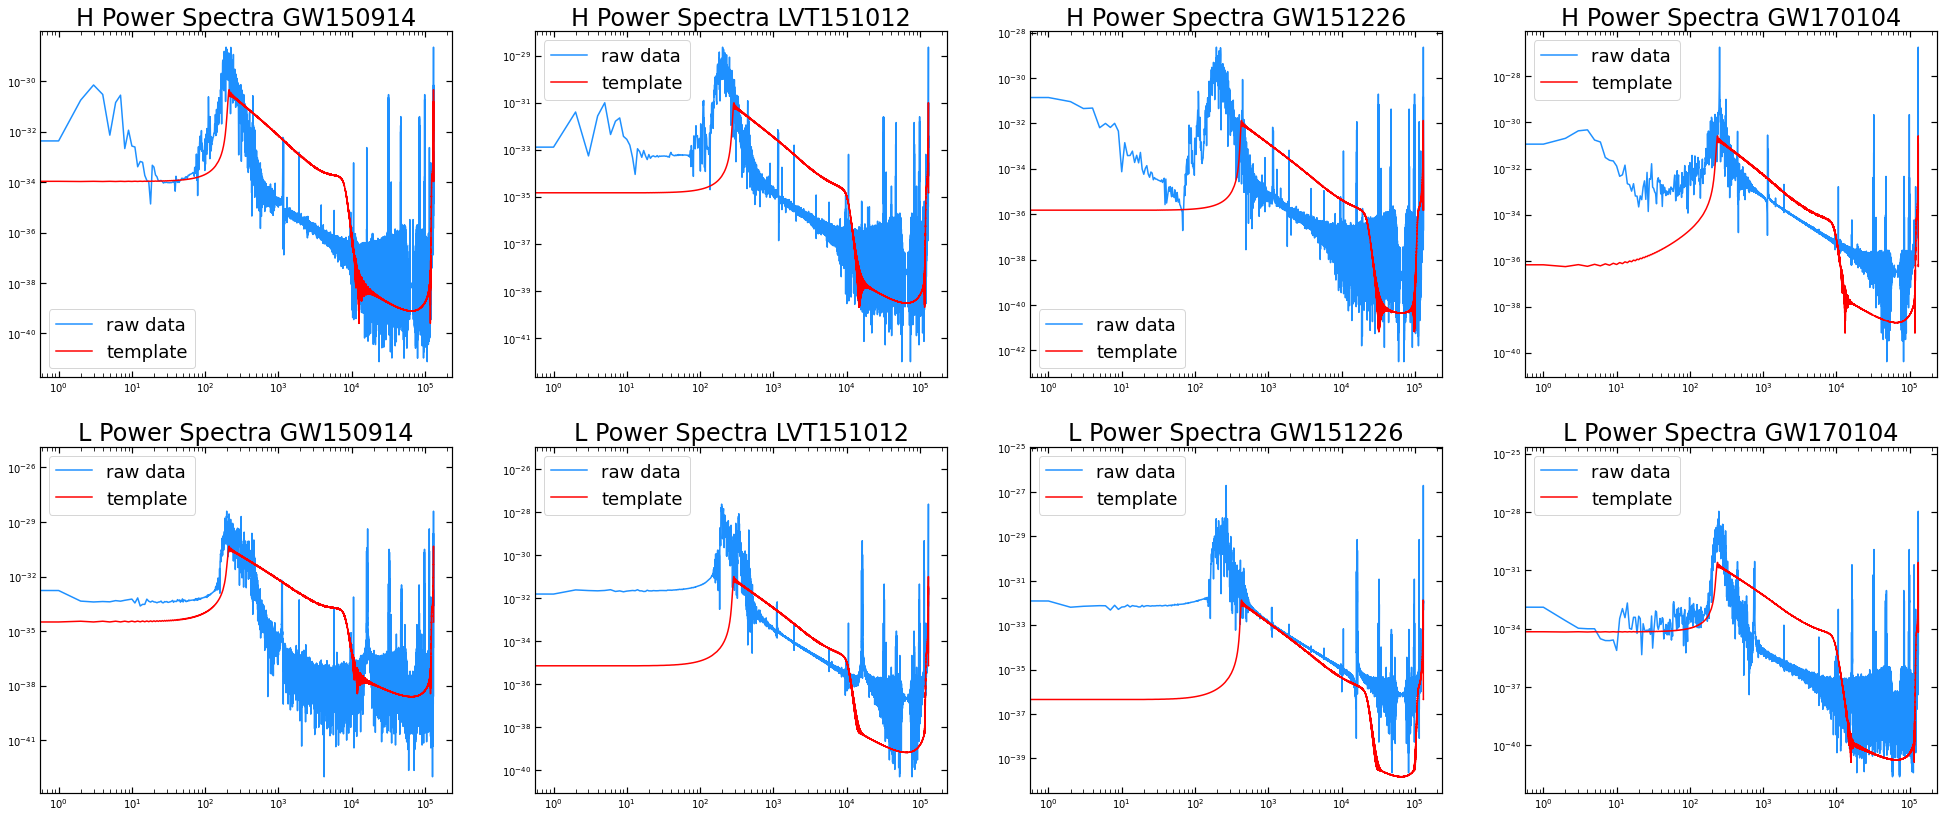

In [233]:
nrows, ncols = 2,4
fig,ax = plt.subplots(nrows,ncols, figsize=[34,14])

for j in range(ncols):
    ax[0,j].loglog(power_spec(H1_data[j][0]), color='dodgerblue', label='raw data')
    ax[0,j].loglog(power_spec(H_templates[j]), color='red', label = 'template')
    ax[0,j].legend(fontsize=18)
    ax[0,j].set_title('H Power Spectra '+str(list_events[j]), fontsize=24)
    ax[1,j].loglog(power_spec(L1_data[j][0]),color='dodgerblue', label='raw data')
    ax[1,j].loglog(power_spec(L_templates[j]),  color='red',label = 'template')
    ax[1,j].legend(fontsize=18)
    ax[1,j].set_title('L Power Spectra '+str(list_events[j]), fontsize=24)

Clearly, the data is very spikey, especially at larger frequencies, so we can try to smooth this out.

One method of doing this is to average over chunks of the power spectrum and apply a window function to minimize the spectral leakage. One standardized way of doing this is using Welch's method (built-in for `scipy`). From the `scipy` documentation, Welch's method is described as; 

'Welch’s method computes an estimate of the power spectral density by dividing the data into overlapping segments, computing a modified periodogram for each segment and averaging the periodograms.'

Following this, we can convolve the resulting PSD with an extended function to further smooth over some of the spikes/jitteriness in the noise.

Our choice of window function must avoid tapering the data/template where the signal is not very small. After some looking around, it appears like the 'Tukey' or cosine-tapered window will be sufficient for our data. I have plotted the 'Tukey' window function for reference below, next to a plot of it multiplied by the data and finally, and plot of the PSD of the data and template after multiplication by the 'Tukey' function.

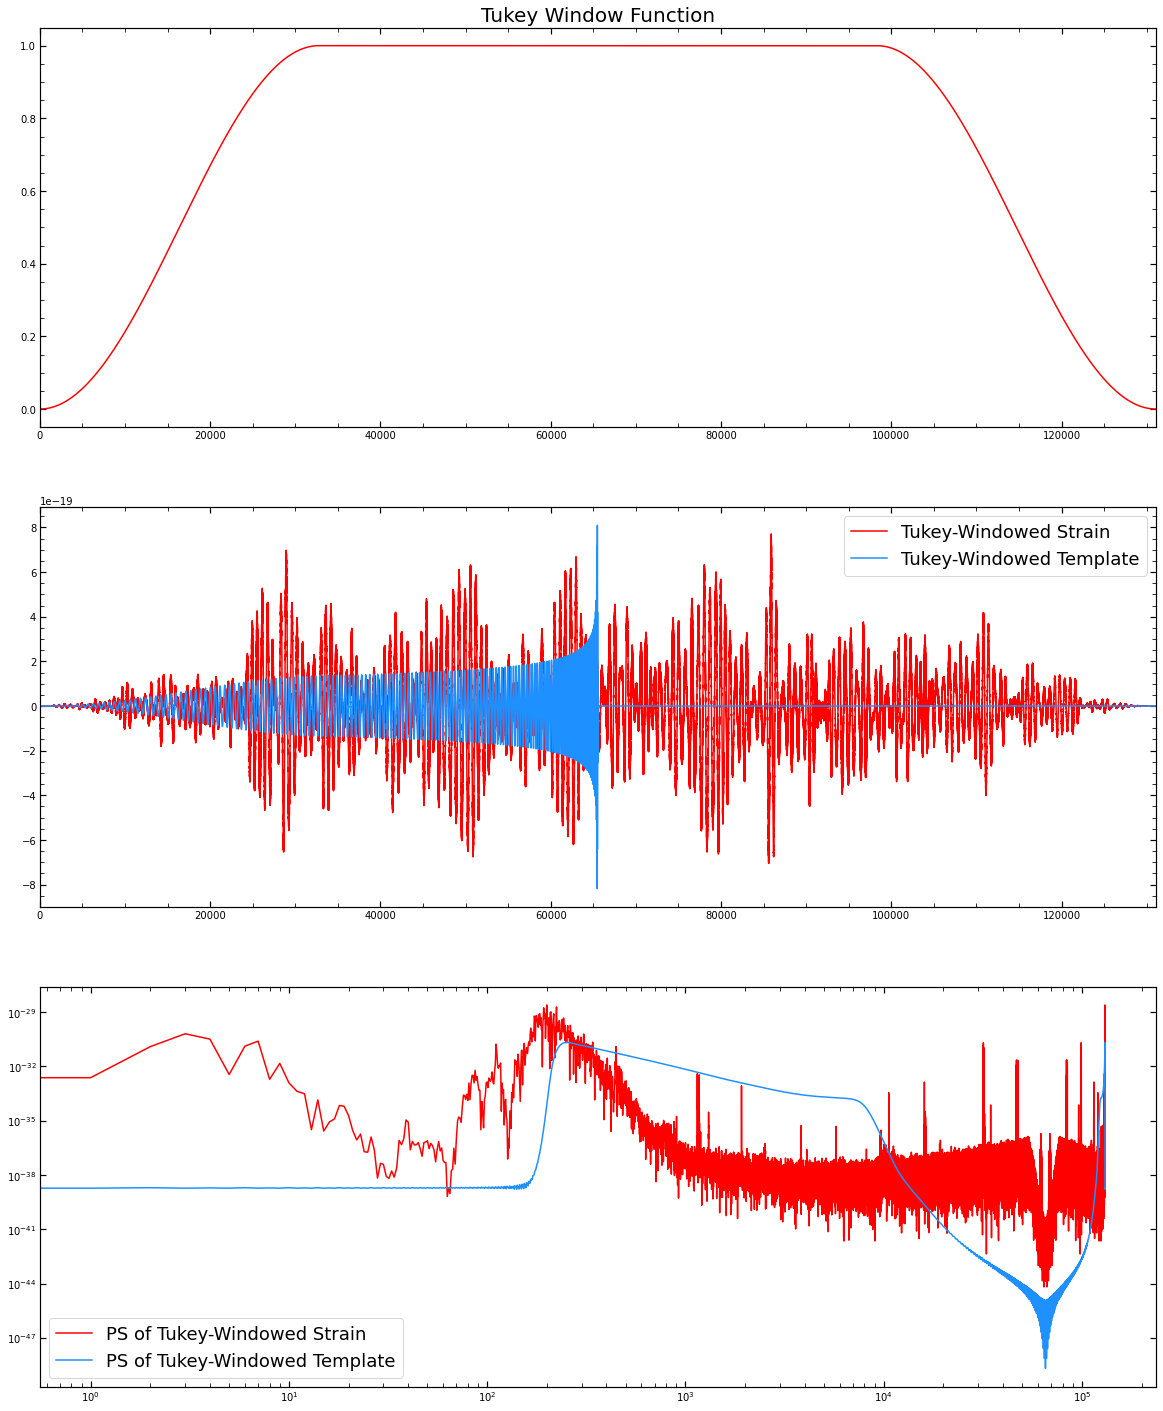

In [10]:
# For first event at Hanford

H1_strain = H1_data[0][0]
Nx = len(H1_strain)
freqs=np.arange(Nx)
tukey = sig.get_window('tukey', Nx=Nx)
H1_strain_tukey = H1_strain*tukey
H_temp_tukey = H_templates[0]*tukey

fig, ax = plt.subplots(3, figsize=[20,25])
ax[0].plot(freqs,tukey,  color='red')
ax[0].set_xlim(xmin=freqs[0], xmax=freqs[-1])
ax[0].set_title('Tukey Window Function',fontsize=20)
ax[1].plot(H1_strain_tukey, color='red', label='Tukey-Windowed Strain')
ax[1].plot(H_temp_tukey, color='dodgerblue', label='Tukey-Windowed Template')
ax[1].set_xlim(xmin=freqs[0], xmax=freqs[-1])
ax[1].legend(fontsize=18)
ax[2].loglog(power_spec(H1_strain_tukey), color='red', label='PS of Tukey-Windowed Strain')
ax[2].loglog(power_spec(H_temp_tukey), color='dodgerblue', label='PS of Tukey-Windowed Template')
ax[2].legend(fontsize=18);

Now we can average over the PSDs after multiplication by the window function of the different data sets, which should all have identical noise models. We will do this separately for each detector. After this, we can convolve our averaged and windowed PSDs with an an extended function and obtain our final noise model. In this instance, we will perform a smoothing convolution with a Gaussian.

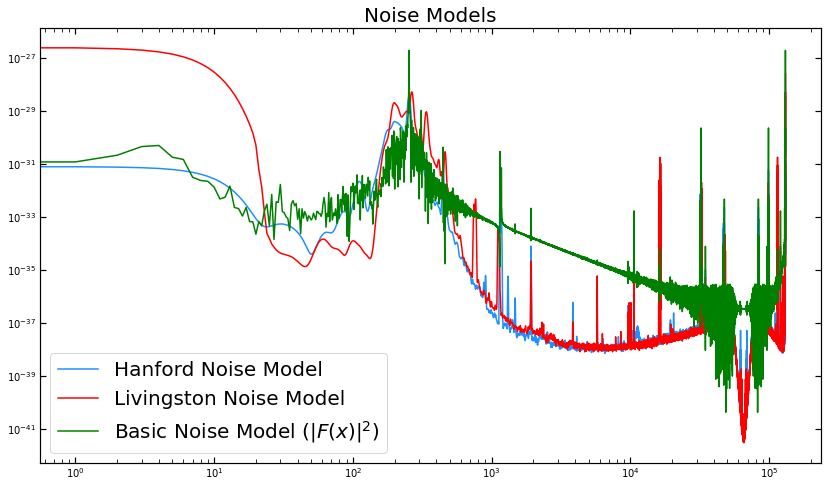

In [130]:
def ave_noise_wind(data_sets): # data sets all of same size
    Nsets = len(data_sets)
    Npt = len(data_sets[0])
    wind = sig.get_window('tukey', Nx=Npt)
    avg_PSD = 0*data_sets[0]
    
    for i in range(Nsets):
        wind_dat = data_sets[i]*wind
        avg_PSD += power_spec(wind_dat)
    
    return avg_PSD/Nsets
        
def smooth_conv(power_spec, sigma=5): # convolution to smooth over PSD, with Gaussian
    smoothed_ps = gaussian_filter(power_spec, sigma)
    return smoothed_ps

def get_noise_model(data_sets):
    ave_wind_noise_ps = ave_noise_wind(data_sets)
    smooth_noise_ps = smooth_conv(ave_wind_noise_ps)
    return smooth_noise_ps

H_strain = [H1_data[i][0] for i in range(N_events)]
L_strain = [L1_data[j][0] for j in range(N_events)]

# Now our noise models for Hanford and Livingston

H1_noise_mod = get_noise_model(H_strain)
L1_noise_mod =  get_noise_model(L_strain)

fig, ax = plt.subplots(figsize=[14,8])

ax.loglog(H1_noise_mod, color = 'dodgerblue', label='Hanford Noise Model')
ax.loglog(L1_noise_mod, color = 'red', label='Livingston Noise Model')
ax.loglog(power_spec(H1_data[j][0]), color='green', label='Basic Noise Model ($|F(x)|^2$)')
ax.legend(fontsize=20)
ax.set_title('Noise Models', fontsize=20);

# Q1b) Use the noise model to search for four sets of events using a matched filter. The mapping between data and templates can be found in the json file.

Now we can apply the matched filter method, although filter we will need to pre-whiten the template and the data. This is done following the linear algebra presented in class.

In [91]:
def pre_whiten(data, noise, dt=0):
    fft_dat_wind = np.fft.fft(data*sig.get_window('tukey', Nx=len(data)))
    white_fft_dat_wind = fft_dat_wind/np.sqrt(noise)
    white_data = np.real(np.fft.ifft(white_fft_dat_wind))
    return white_data

def matched_filter(data, template, noise):
    white_data = pre_whiten(data,noise)
    white_temp = pre_whiten(template,noise)
    fft_white_data = np.fft.fft(white_data)
    conj_fft_white_temp = np.conjugate(np.fft.fft(white_temp))
    MF = np.real(np.fft.ifft(fft_white_data*conj_fft_white_temp))
    return MF

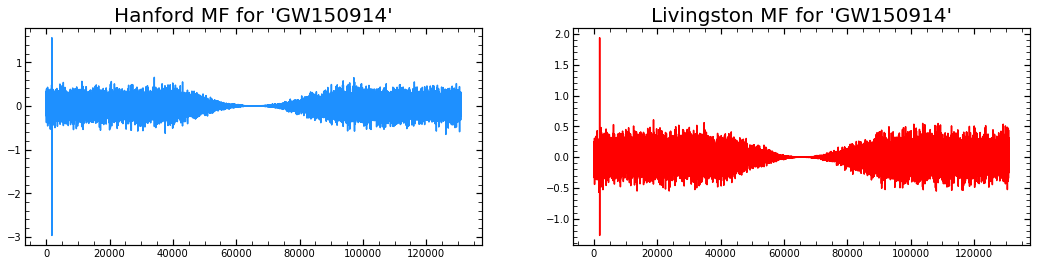

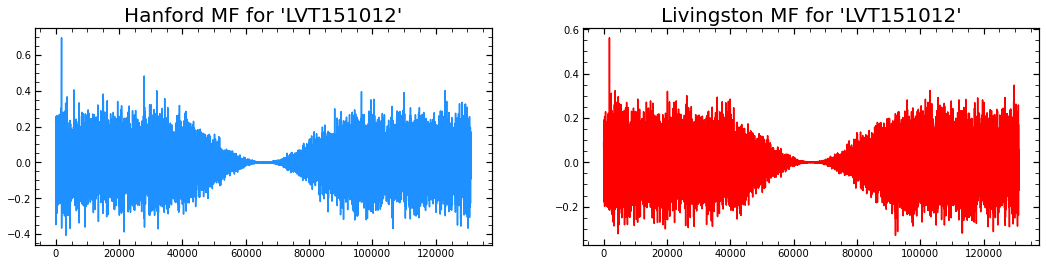

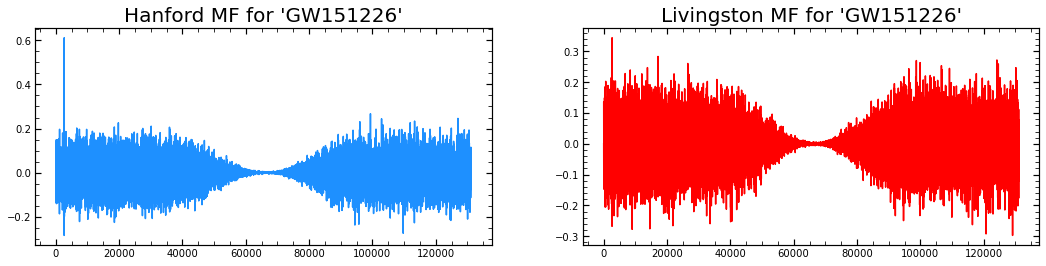

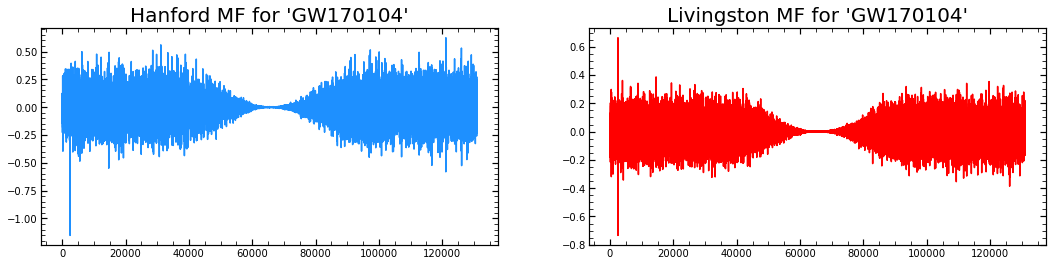

In [123]:
H1_mf = [] # list of all Matched Filters for each event
L1_mf = []

for i in range(N_events):
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(18, 4))
    H_mf = matched_filter(H_strain[i],H_templates[i], H1_noise_mod)
    H1_mf.append(H_mf)
    L_mf = matched_filter(L_strain[i],L_templates[i], L1_noise_mod)
    L1_mf.append(L_mf)
    ax[0].plot(H_mf, color='dodgerblue', label = 'Hanford')
    ax[1].plot(L_mf, color='red', label='Livingston')
    ax[0].set_title('Hanford MF for ' +repr(list_events[i]), fontsize=20)
    ax[1].set_title('Livingston MF for ' +repr(list_events[i]), fontsize=20)

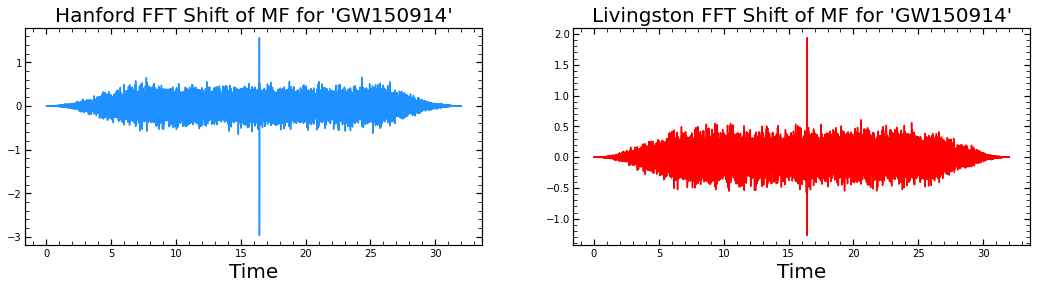

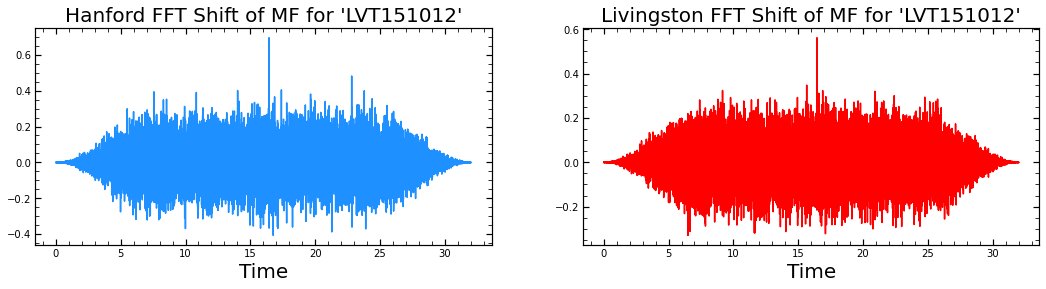

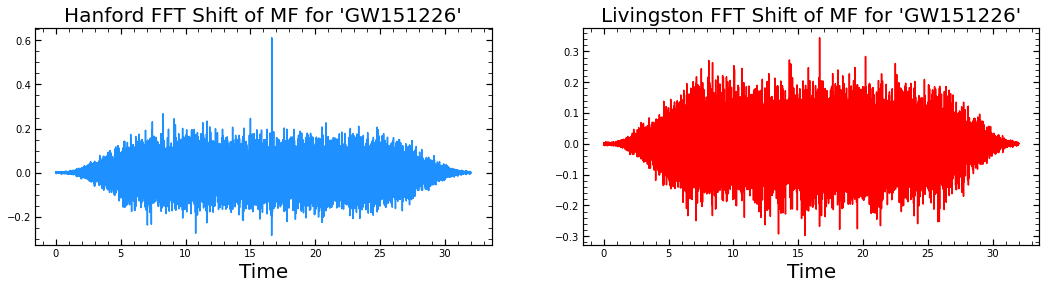

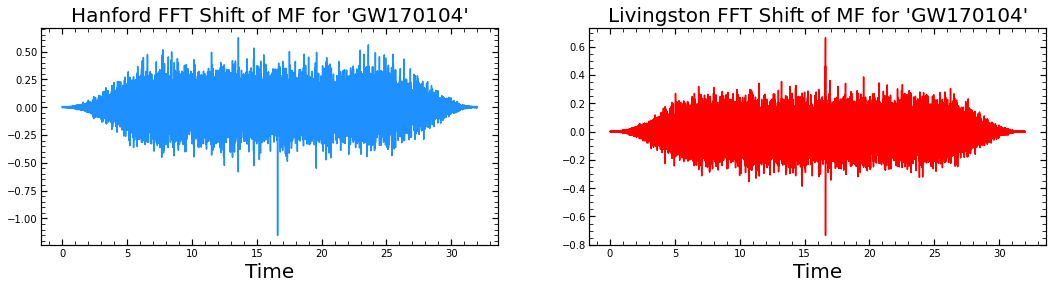

In [136]:
# Compute the FFT shift of the matched filter output as we saw in class - easier to see potential GWs

for i in range(N_events):
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(18, 4))
    H_t = np.arange(0, len(H_strain[i])*H1_dt[i], H1_dt[i])
    L_t = np.arange(0, len(L_strain[i])*L1_dt[i], L1_dt[i])
    H_shift_t = np.fft.fftshift(H_t)
    L_shift_t = np.fft.fftshift(L_t)
    ax[0].plot(H_shift_t, H1_mf[i], color='dodgerblue', label = 'Hanford')
    ax[1].plot(L_shift_t, L1_mf[i], color='red', label='Livingston')
    ax[0].set_title('Hanford FFT Shift of MF for ' +repr(list_events[i]), fontsize=20)
    ax[1].set_title('Livingston FFT Shift of MF for ' +repr(list_events[i]), fontsize=20)
    ax[0].set_xlabel('Time', fontsize=20)
    ax[1].set_xlabel('Time', fontsize=20)

Clearly, there are some detections that have occurred, with some events more obvious than others.

# Q1c) Estimate a noise for each event, and from the output of the matched filter, give a signal-to-noise ratio for each event, both from the individual detectors, and from the combined Hanford and Livingston events.

We can compute the noise for each event by calculating the standard deviation of the matched filter for each event (at each detector location). To compute the SNR, we can find the 'noise' part of the ratio as the standard deviation in the matched filter for each event, and we can take the 'signal' part of this ratio as the absolute value of the maximum of the matched filter for each event. Combining the two SNRs from the 2 detectors for each event added in quadrature, we get can calculate the combined SNR for each event. However, when we estimate the noise, we want to ensure that the actual signal are not included in the standard deviation calculation and therefore, we can find a suitable range of the MF where the signals are not present.

In [140]:
def get_SNR(mf): # adjust so noise is only calculated over range with no signal
    mf_max_ind = np.argmax(np.abs(mf))
    mf_N_low_ind, mf_N_high_ind = mf_max_ind+1500, mf_max_ind+6500 # take over interval without signal
    N = np.std(mf[mf_N_low_ind:mf_N_high_ind])
    S = np.abs(mf[mf_max_ind])
    SNR = S/N
    return SNR, N

In [141]:
for i in range(N_events):
    H1_SNR, H1_noise = get_SNR(H1_mf[i])
    L1_SNR, L1_noise = get_SNR(L1_mf[i])
    overall_SNR = np.sqrt(H1_SNR**2 + L1_SNR**2)
    print('{}: Hanford N = {:.3f} and SNR = {:.2f}; Livingston N = {:.3f} and SNR = {:.2f} and combined SNR = {:.2f}'.format(list_events[i], H1_noise, H1_SNR, L1_noise, L1_SNR, overall_SNR))  

GW150914: Hanford N = 0.160 and SNR = 18.55; Livingston N = 0.152 and SNR = 12.75 and combined SNR = 22.51
LVT151012: Hanford N = 0.099 and SNR = 7.00; Livingston N = 0.102 and SNR = 5.53 and combined SNR = 8.92
GW151226: Hanford N = 0.061 and SNR = 10.00; Livingston N = 0.076 and SNR = 4.56 and combined SNR = 10.99
GW170104: Hanford N = 0.140 and SNR = 8.21; Livingston N = 0.096 and SNR = 7.66 and combined SNR = 11.23


# Q1d) Compare the SNR you get from the scatter in the matched filter to the analytic SNR you expect from your noise model. How close are they? If they disagree, can you explain why?

The analytic SNR from our noise model can be written as, 

\begin{equation}
\text{SNR} = \sqrt{(A^T N^{-1} A)}
\end{equation}

In [ ]:
def SNR(template, noise):
    # Window the template
     template_win = template*np.hanning(len(template))
    # Fourier transform
    template_ft = np.fft.rfft(template_win)
    # Whiten data
    template_white = whiten(template, noise)
    
    # Calculate the SNR
    SNRsqr_ft = template_ft.conjugate()*template_ft/noise
    SNR_ft = np.sqrt(SNRsqr_ft)
    SNR = np.fft.irfft(SNR_ft)
    SNRmax = SNR.max()
    return SNRmax

In [161]:
def analytic_SNR(strain, template, noise, dt = 0):
    #fft_strain_white = np.fft.fft(pre_whiten(strain, noise, dt=0))
    fft_template_white = np.fft.fft(pre_whiten(template, noise, dt=0))
    fft_SNR = fft_template_white * fft_template_white.conjugate() / noise
    SNR = np.fft.irfft(fft_SNR)
    return np.max(SNR)

In [162]:
for i in range(N_events):
    H1_analyt_SNR = analytic_SNR(H1_mf[i],H_templates[i], H1_noise_mod, H1_dt[i])
    L1_analyt_SNR = analytic_SNR(L1_mf[i],L_templates[i], L1_noise_mod, L1_dt[i])
    overall_analyt_SNR = np.sqrt(H1_analyt_SNR**2 + L1_analyt_SNR**2)
    print('{}: Hanford analytic SNR = {:.2f}; Livingston analytic SNR = {:.2f} and combined SNR = {:.2f}'.format(list_events[i],H1_analyt_SNR, L1_analyt_SNR, overall_analyt_SNR))  

GW150914: Hanford analytic SNR = 156270722750209911287157759965158117998592.00; Livingston analytic SNR = 126139661050757196108015349425566147149824.00 and combined SNR = 200827669604745683798309356682251906056192.00
LVT151012: Hanford analytic SNR = 57081534109873034491678717343672114872320.00; Livingston analytic SNR = 43725914720952854066949458306628249976832.00 and combined SNR = 71904500238306646167401495218669135855616.00
GW151226: Hanford analytic SNR = 23447894167791197707321952349743625535488.00; Livingston analytic SNR = 17861463749180881711708376957916429680640.00 and combined SNR = 29476017847857931158970375249159887257600.00
GW170104: Hanford analytic SNR = 99444584477920902560542634681114212433920.00; Livingston analytic SNR = 78309988184948021140116748381571843620864.00 and combined SNR = 126576773665286039328932320695090726043648.00


# Q1e) From the template and the noise model, find the frequency from each event where half the weight comes from above that frequency and half below.

In [216]:
def freq_half_weight(template, noise, freq):
    temp_white = pre_whiten(template, noise)
    fft_temp_white = np.real(np.fft.fft(temp_white))
    normcum_fft_temp_white = np.cumsum(np.abs(fft_temp_white)) / np.sum(np.abs(fft_temp_white)) # normed cumulative sum
    #half_weight = np.percentile(np.abs(fft_temp_white), 50)
    #print(half_weight)
    half_weight_ind = np.where(normcum_fft_temp_white>=0.5)[0]
    print(half_weight_ind)
    return freq[half_weight_ind[0]]

In [218]:
for i in range(4):
    H_freq = np.fft.rfftfreq(len(H_strain[i]), H1_dt[i])
    L_freq = np.fft.rfftfreq(len(L_strain[i]), L1_dt[i])
    print('Event {}: half-weight frequency for Hanford = {:.2f} Hz, Livingston = {:.2f} Hz'.format(list_events[i], freq_half_weight(H_templates[i], H1_noise_mod, H_freq), freq_half_weight(L_templates[i], L1_noise_mod, L_freq)))
    

[ 65536  65537  65538 ... 131069 131070 131071]
[ 65536  65537  65538 ... 131069 131070 131071]
Event GW150914: half-frequency value for Hanford = 2048.00 Hz, Livingston = 2048.00 Hz
[ 65536  65537  65538 ... 131069 131070 131071]
[ 65536  65537  65538 ... 131069 131070 131071]
Event LVT151012: half-frequency value for Hanford = 2048.00 Hz, Livingston = 2048.00 Hz
[ 65536  65537  65538 ... 131069 131070 131071]
[ 65536  65537  65538 ... 131069 131070 131071]
Event GW151226: half-frequency value for Hanford = 2048.00 Hz, Livingston = 2048.00 Hz
[ 65536  65537  65538 ... 131069 131070 131071]
[ 65536  65537  65538 ... 131069 131070 131071]
Event GW170104: half-frequency value for Hanford = 2048.00 Hz, Livingston = 2048.00 Hz


In [206]:
freq = np.fft.rfftfreq(len(H_strain[0]), H1_dt[0])
def half_freq(template, noise):
    # Window and whiten the template
    #template_win = template*np.hanning(len(template))
    template_white = pre_whiten(template, noise)
    template_white_ft = np.fft.rfft(template_white)
    
    # Get the cumulative sum of the power spectrum of the whitened template
    template_white_ft_cum = np.cumsum(np.abs(template_white_ft))
    
    # Find where it is equal to half of its maximum value
    diff = np.abs(template_white_ft_cum - template_white_ft_cum.max()/2) # vector of distances from the half value
    idx = np.where(diff == diff.min())[0][0]
    freq_half = freq[idx]    
    return freq_half

for i in range(4):
    print('Event {:d}: half-frequency value for Hanford is {:.2f} Hz, and it is {:.2f} Hz for Livingston.'.format(i+1, half_freq(H_templates[i], H1_noise_mod), half_freq(L_templates[i], L1_noise_mod)))

Event 1: half-frequency value for Hanford is 124.47 Hz, and it is 134.66 Hz for Livingston.
Event 2: half-frequency value for Hanford is 118.34 Hz, and it is 132.53 Hz for Livingston.
Event 3: half-frequency value for Hanford is 140.53 Hz, and it is 159.69 Hz for Livingston.
Event 4: half-frequency value for Hanford is 123.41 Hz, and it is 135.38 Hz for Livingston.


In [47]:
# First average over the chopped up PSD and apply a Tukey window (flat-top) using Welch's method

noise = power_spec(H1_data[0][0])
freqs, noise_power_spec = sig.welch(noise, window='tukey', fs=1/H1_dt[0], nperseg=4000) # will need to interpolate later
Nx = len(noise_ave)
#freqs=np.arange(Nx)
tukey = sig.get_window('tukey', Nx=Nx)
#noise_power_spec=noise_ave
plt.plot(tukey)
plt.show()

# Now smooth over the PSD using a convolution with an extended function

n_smooth=6
smooth_noise_power_spec = np.convolve(noise_power_spec, np.exp(-np.arange(len(noise_power_spec))**2 / 2), mode='same')
#smooth_noise_power_spec = np.convolve(noise_ave, np.ones(n_smooth)/n_smooth, mode='same')



# compare progress of noise after each method in 

plt.loglog(freqs,noise_power_spec, color='red', label="Welch's Method")
plt.loglog(freqs,smooth_noise_power_spec, color='dodgerblue', label="Welch's Method + Smoothing")
plt.legend(fontsize=14)

# Linearly interpolate after loss of points from Welch's method

noise_spec_interp = intp.interp1d(freqs, smooth_noise_power_spec, kind='linear')

NameError: name 'noise_ave' is not defined

# Q1f) How well can you localize the time of arrival (horizontal shift of your matched filter). The positions of gravitational wave events are inferred by comparing their arrival times at different detectors. What is the typical positional uncertainty you might expect given that the detectors are a few thousand $km$ apart.

We know that gravitational waves travel at the speed of light $c$, so for a pair of detectors located $\approx 10^3 \, km$, we would expect that the typical positional uncertainty (in time, which we plotted in the FFT shift of the MF) is on the order of, 

\begin{equation}
\delta t \approx \frac{10^6 \ m}{3*10^8 \, \frac{m}{s}} \approx 3.33*10^{-3} \, s.
\end{equation}

131072

To develop a noise model for the data, we need to apply windowing which will allow us to avoid FFT ringing and smooth out spectral features. We can also smooth by convolving with an extended function, and pre-whiten. Pre-whitening the data will try to get the noise on the data to look like white noise. Autocorrelation of white noise is a delta function. Following this, we can convolve the the resulting PSD to further smooth over some of the spikes/jitteriness of the data.

First we generate our noise model and then use our noise model to do the pre-whitening.

As suggested in tutorial, one way to move beyond the simplest assumption that the noise is $|F(\text{strain})|^2$, is to average over average the PSD over several intervals, as the noise should remain constant throughout these intervals. Pre-whitening the strain and template with $N^{-1/2}$ and applying a window function to our strain, we can then apply the matched filter formula, $MF = F^{-1}[F(\text{template}) \cdot F(\text{strain})]$.

In [88]:
'''
for i in range(N_events*2):
    if i < 4: # Hanford
        event='H'
        mf = matched_filter(H_strain[i],H_templates[i], H1_noise_mod)
        H1_mf.append(mf)
        title = 'MF Hanford: '+repr(list_events[i])
    else: # Livingston
        event='L'
        mf = matched_filter(L_strain[i-4],L_templates[i-4], L1_noise_mod)
        L1_mf.append(mf)
        title = 'MF Livingston: '+repr(list_events[i-4])
    if plot_mf:
        fig1, ax1 = plt.subplots(figsize=[14, 4])
        ax1.set_title(title, fontsize=20)
        ax1.plot(mf, color='dodgerblue', alpha=0.75)
        if save_fig:
        fig1.savefig('mf_event_'+event+repr(i)+'.png')
    '''

reading file  LOSC_Event_tutorial/H-H1_LOSC_4_V2-1126259446-32.hdf5
